In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import json
from PIL import Image
from tqdm import tqdm
import random
import torchvision.transforms as transforms
# import VLR.Bisenetv1_for_github.custom_transforms as c_transforms

In [2]:
img_dir = '/home/ishan/datasets/celeba/images'
alpha_dir = '/home/ishan/datasets/celeba/masks'
seg_dir = '/home/ishan/datasets/celeba/masks'

img_file_names = sorted([f for f in os.listdir(img_dir)])
alpha_file_names = [i[:-4]+'_mask.png' for i in img_file_names]
seg_file_names = [i[:-4]+'_mask.png' for i in img_file_names]
# seg_file_names_color = sorted([f for f in os.listdir(seg_dir) if f.endswith('.jpg')])

img_file_names = [os.path.join(img_dir, file_name) for file_name in img_file_names]
alpha_file_names = [os.path.join(alpha_dir, file_name) for file_name in alpha_file_names]
seg_file_names = [os.path.join(seg_dir, file_name) for file_name in seg_file_names]
# seg_file_names_color = [os.path.join(seg_dir, file_name) for file_name in seg_file_names_color]


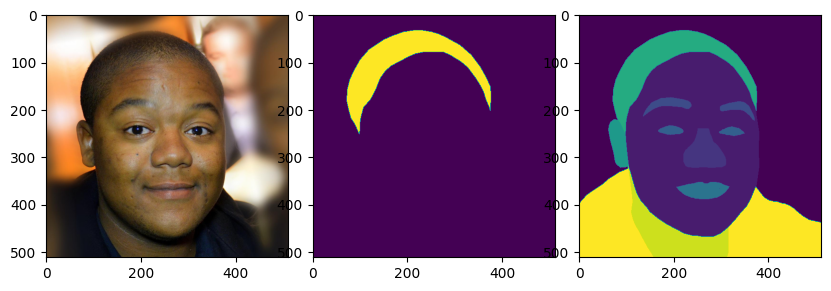

In [13]:
img_idx = 2

def get_img_and_masks(index):
    img = mpimg.imread(img_file_names[index])
    alpha = cv2.imread(alpha_file_names[index])
    alpha_mask = cv2.cvtColor(alpha, cv2.COLOR_BGR2GRAY)
    # print(np.unique(alpha_mask))
    alpha_mask = np.where(alpha_mask == 8, 1, 0)
    # alpha_mask =  np.where(alpha*255 > 45, 255, 0)
    seg_mask = mpimg.imread(seg_file_names[index])
    # seg_color_mask = mpimg.imread(seg_file_names_color[index])

    # Resize alpha mask
    resized_img = cv2.resize(
        img.astype(np.uint8),
        seg_mask.shape[::-1],
        interpolation=cv2.INTER_CUBIC
        )
    resized_alpha_mask = cv2.resize(
        alpha_mask.astype(np.uint8),
        seg_mask.shape[::-1],
        interpolation=cv2.INTER_CUBIC
        )
    
    return resized_img, resized_alpha_mask, seg_mask

img, resized_alpha_mask, seg_mask = get_img_and_masks(img_idx)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

axs[0].imshow(img)
axs[1].imshow(resized_alpha_mask)
axs[2].imshow(seg_mask)

# for i in range(3):
    # axs[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

In [6]:
# Create hair mask
hair_mask = resized_alpha_mask

In [10]:
# def get_final_hair_mask(hair_mask, resized_alpha_mask):

#   # Define dilation kernel
#   dilation_factor = 40
#   kernel = np.ones((dilation_factor, dilation_factor), np.uint8)  

#   # Dilate hair mask
#   dilated_mask = cv2.dilate(hair_mask.astype(np.uint8), kernel, iterations=1)

#   # Combine with alpha mask  
#   combined_hair_mask = cv2.bitwise_and(dilated_mask, resized_alpha_mask)
  
#   # Filter out rest of human  
#   combined_hair_mask = np.where(roh_mask==1,0,combined_hair_mask)

#   # Find contours  
#   contours, _ = cv2.findContours(combined_hair_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#   # Get largest contour  
#   largest_contour = max(contours, key=cv2.contourArea)

#   # Create mask from contour
#   final_mask = np.zeros_like(combined_hair_mask)
#   cv2.drawContours(final_mask, [largest_contour], 0, 255, -1)

#   # Return final mask
#   final_combined_hair_mask = cv2.bitwise_and(combined_hair_mask, final_mask)
#   return final_combined_hair_mask, dilated_mask, combined_hair_mask

# final_combined_hair_mask, dilated_mask, combined_hair_mask = get_final_hair_mask(hair_mask, resized_alpha_mask)

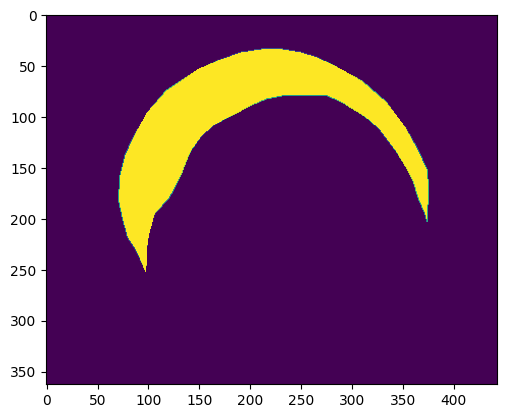

In [7]:
# # Find the contours in the mask

def get_crop_coords(final_combined_hair_mask):

  # Find contours
  contours, _ = cv2.findContours(final_combined_hair_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Find largest contour
  largest_contour = max(contours, key=cv2.contourArea)

  # Calculate centroid
  M = cv2.moments(largest_contour)
  if M["m00"] != 0:
      cx = int(M["m10"] / M["m00"])  
      cy = int(M["m01"] / M["m00"])
  else:
      cx, cy = 0, 0

  crop_size = 512

  # Calculate crop coordinates
  x1 = max(0, cx - crop_size//2)
  x2 = min(final_combined_hair_mask.shape[1], cx + crop_size//2)
  y1 = max(0, cy - crop_size//2) 
  y2 = min(final_combined_hair_mask.shape[0], cy + crop_size//2)

  return x1, x2, y1, y2

x1, x2, y1, y2 = get_crop_coords(hair_mask)
cropped_mask = hair_mask[y1:y2, x1:x2]
cropped_mask_for_filtering = hair_mask[y1:y2, x1:x2]

plt.imshow(cropped_mask)
plt.show()

In [8]:
img.shape

(512, 512, 3)

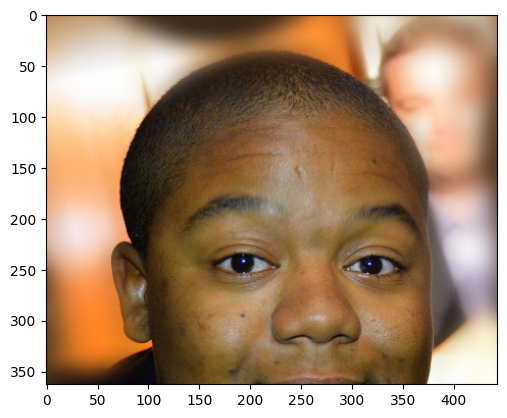

In [9]:
cropped_img = img.copy()[y1:y2, x1:x2,:]
plt.imshow(cropped_img)

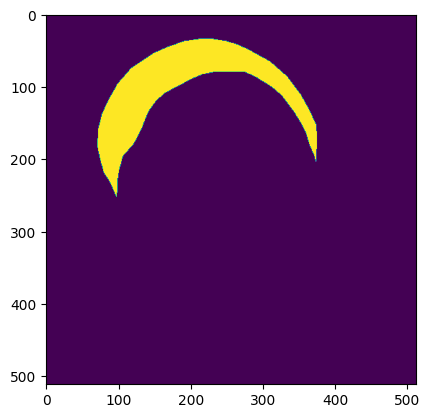

In [10]:
# Pasting cropped image back onto original image
larger_image = Image.fromarray(np.zeros_like(hair_mask))
smaller_image = Image.fromarray(cropped_mask)

larger_image.paste(smaller_image, (x1, y1))
plt.imshow(larger_image)

In [11]:
# Experimenting with patching

def get_patches(cropped_img, cropped_mask, cropped_mask_for_filtering):

    resized_cropped_mask = cv2.resize(cropped_mask, (512, 512), interpolation = cv2.INTER_NEAREST)
    resized_cropped_mask_for_filtering = cv2.resize(cropped_mask_for_filtering, (512, 512), interpolation = cv2.INTER_NEAREST)
    resized_cropped_img = cv2.resize(cropped_img, (512, 512), interpolation = cv2.INTER_NEAREST)
    # Get image dimensions
    height, width = resized_cropped_mask.shape

    # Set number of patches
    num_patches = 64

    # Calculate patch size  
    patch_size = int(width / np.sqrt(num_patches))

    # Initialize empty lists
    patches = [] 
    filtered_patches = []
    patch_map_linear = []
    img_patches = []

    idx = 0
    # Loop over image and extract patches  
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):

            patch = resized_cropped_mask[i:i+patch_size, j:j+patch_size]
            patch_inspect = resized_cropped_mask_for_filtering[i:i+patch_size, j:j+patch_size]
            img_patch = resized_cropped_img[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            img_patches.append(img_patch)

            unique = np.unique(patch_inspect)

            if len(unique)>1 and 1 in unique:
                num_matches = (patch_inspect==1).sum()
                fraction = num_matches / patch.size
                
                if 0.3 < fraction < 0.9: 
                    filtered_patches.append(patch)  
                    patch_map_linear.append(idx)

            idx += 1

    return img_patches, patches, patch_map_linear

img_patches, patches, patch_map_linear = get_patches(cropped_img, cropped_mask, cropped_mask_for_filtering)
print(len(patches), len(patch_map_linear))
print(patch_map_linear)

64 10
[10, 12, 13, 17, 18, 22, 25, 26, 30, 33]


(64, 64)


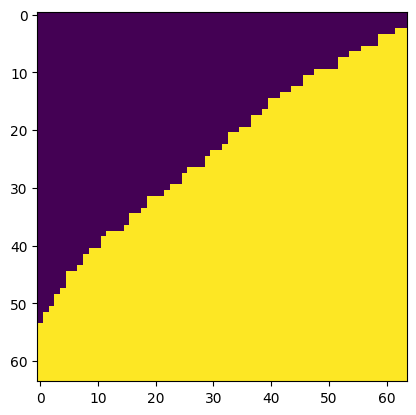

(64, 64)


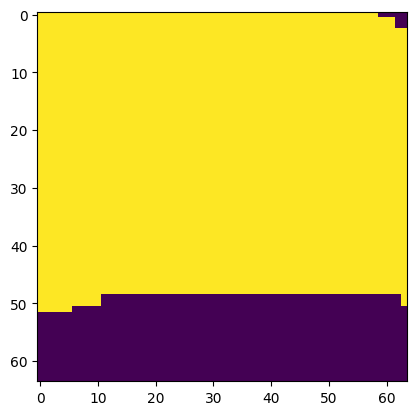

(64, 64)


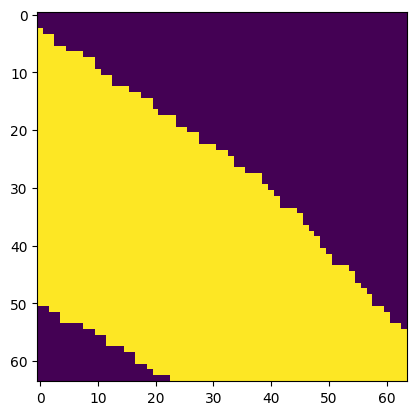

(64, 64)


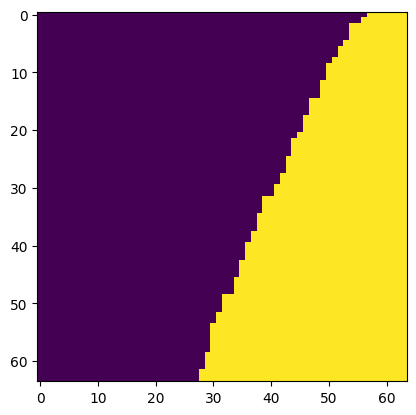

(64, 64)


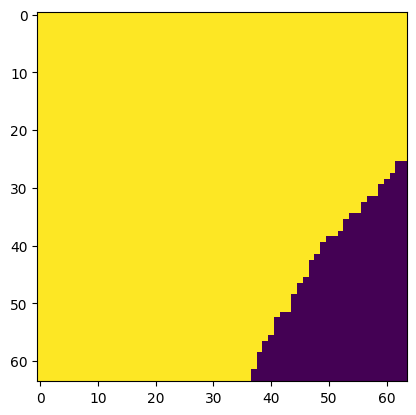

(64, 64)


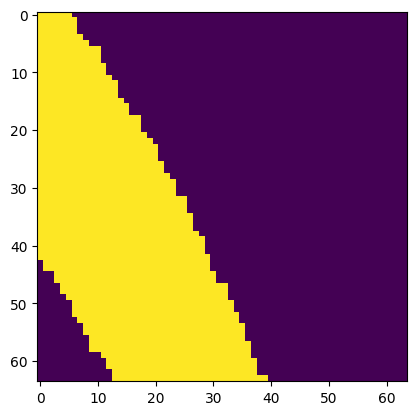

(64, 64)


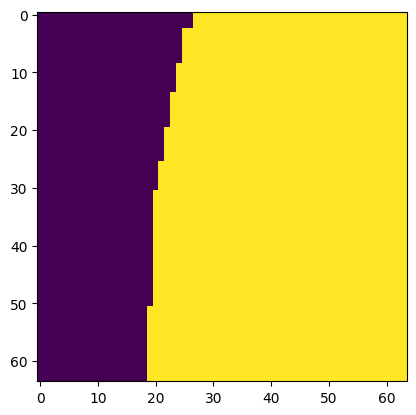

(64, 64)


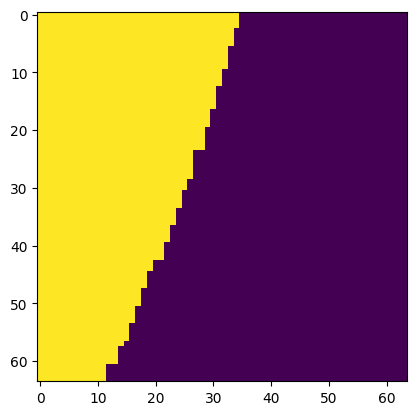

(64, 64)


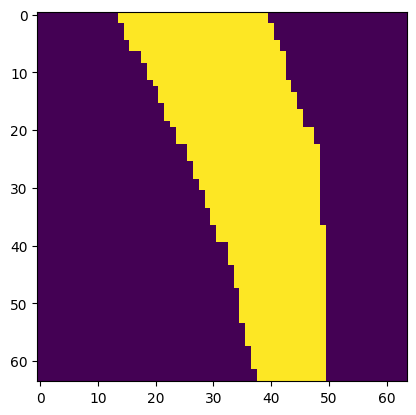

(64, 64)


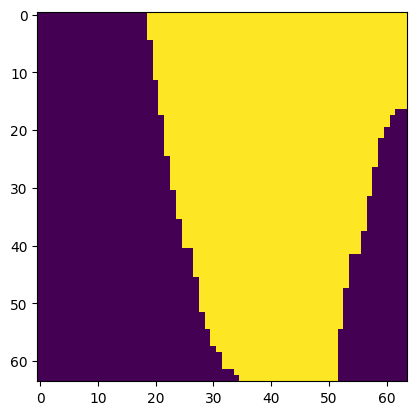

In [12]:
filtered_patches = [patches[i] for i in patch_map_linear]
for p in filtered_patches:
    plt.imshow(p)
    print(p.shape)
    plt.show()

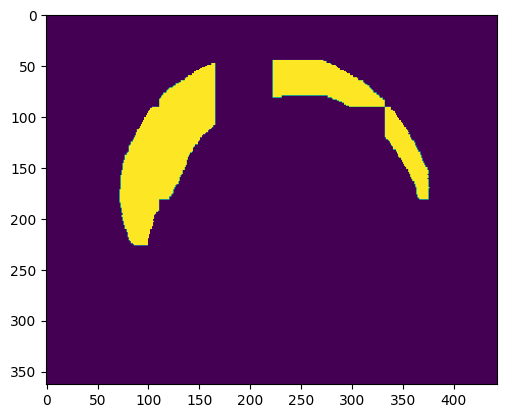

In [14]:
def combine_patches(patches, patches_per_row, total_patches, only_filtered_patches=False):
    # Calculate the number of rows
    num_rows = total_patches // patches_per_row
    
    # Get the dimensions of the first patch
    patch_height, patch_width = patches[0].shape
    
    # Create a new array with the combined dimensions
    combined_width = patch_width * patches_per_row
    combined_height = patch_height * num_rows
    combined_image = np.zeros((combined_height, combined_width), dtype=patches[0].dtype)
    
    if only_filtered_patches: 
        # Iterate over the filtered patches and place them into the combined image
        for i, patch in enumerate(filtered_patches):
            idx = patch_map_linear[i]
            row = idx // patches_per_row
            col = idx % patches_per_row
            x = col * patch_width
            y = row * patch_height
            combined_image[y:y+patch_height, x:x+patch_width] = patch
    else:
        # Iterate over the patches and place them into the combined image
        for idx, patch in enumerate(patches):
            row = idx // patches_per_row
            col = idx % patches_per_row
            x = col * patch_width
            y = row * patch_height
            combined_image[y:y+patch_height, x:x+patch_width] = patch
    
    return combined_image

# Combine the patches into a single image
combined_image = combine_patches(patches, patches_per_row=8, total_patches=64, only_filtered_patches=True)
# combined_image = combine_patches(patches, patches_per_row=8, total_patches=64, only_filtered_patches=False)

combined_image.shape

plt.imshow(cv2.resize(combined_image, cropped_mask.shape[::-1]))

In [15]:
img.shape, seg_mask.shape, cropped_mask.shape, patch_map_linear, 

((512, 512, 3),
 (512, 512),
 (363, 443),
 [10, 12, 13, 17, 18, 22, 25, 26, 30, 33])

In [16]:
# Create data dict

data_dict = dict(
    original_image_size = img.shape,
    seg_mask_size = seg_mask.shape,
    cropped_mask_size = cropped_mask.shape,
    patch_map_linear = patch_map_linear,
    patch_coords = [x1, x2, y1, y2],
    patch_coords_format = 'x1, x2, y1, y2',
)

In [20]:
# Get list of all images and masks
# Sort them identically
# loop over the len of list and get the various masks and apply the operations with the functions defined here to get the inter,ediate masks
# and the final patches along with the metadata
# Save the mask patches as pngs and image patches as jpgs with one json file to carry information, all in a folder with the name of the image 

In [17]:
data_dict

{'original_image_size': (512, 512, 3),
 'seg_mask_size': (512, 512),
 'cropped_mask_size': (363, 443),
 'patch_map_linear': [10, 12, 13, 17, 18, 22, 25, 26, 30, 33],
 'patch_coords': [0, 443, 0, 363],
 'patch_coords_format': 'x1, x2, y1, y2'}

In [18]:
img_dir = '/home/ishan/datasets/celeba/images'
alpha_dir = '/home/ishan/datasets/celeba/masks'
seg_dir = '/home/ishan/datasets/celeba/masks'

img_file_names = sorted([f for f in os.listdir(img_dir)])
alpha_file_names = [i[:-4]+'_mask.png' for i in img_file_names]
seg_file_names = [i[:-4]+'_mask.png' for i in img_file_names]

img_file_names = [os.path.join(img_dir, file_name) for file_name in img_file_names]
alpha_file_names = [os.path.join(alpha_dir, file_name) for file_name in alpha_file_names]
seg_file_names = [os.path.join(seg_dir, file_name) for file_name in seg_file_names]


In [19]:
for img_idx in range(len(img_file_names[:10])):
    print(f"\r{img_idx}/{len(img_file_names)}", end=" ")
    try: 
        data_dict = dict()
        resized_img, resized_alpha_mask, seg_mask = get_img_and_masks(img_idx)
        hair_mask = resized_alpha_mask
        # bkg_mask = create_bkg_mask(seg_mask, plot=False)  
        # roh_mask = create_roh_mask(seg_mask, plot=False)

        # final_combined_hair_mask, dilated_mask, combined_hair_mask = get_final_hair_mask(hair_mask, resized_alpha_mask, roh_mask)
        # mask_for_patch_filtering = np.where(final_combined_hair_mask==1, 1, bkg_mask)
        # mask_for_patch_filtering = np.where(roh_mask==1, 3, mask_for_patch_filtering)

        x1, x2, y1, y2 = get_crop_coords(hair_mask)
        cropped_mask = hair_mask[y1:y2, x1:x2]
        cropped_mask_for_filtering = hair_mask[y1:y2, x1:x2]
        cropped_img = resized_img.copy()[y1:y2, x1:x2]

        img_patches, patches, patch_map_linear = get_patches(cropped_img, cropped_mask, cropped_mask_for_filtering)
        # print(len(patches), len(filtered_patches))

        data_dict = dict(
            img_idx = img_idx,
            original_image_size = img.shape,
            seg_mask_size = seg_mask.shape,
            cropped_mask_size = cropped_mask.shape,
            patch_map_linear = patch_map_linear,
            patch_coords = [x1, x2, y1, y2],
            patch_coords_format = 'x1, x2, y1, y2',
            )
        
        folder_name = os.path.basename(img_file_names[img_idx])[:-4]
        patch_folder_path = '/home/ishan/datasets/celeba/patch_folder'
        save_folder_path = os.path.join(patch_folder_path, folder_name)
    except:
        continue
    
    # Create a new folder if it doesn't exist
    # if not os.path.exists(save_folder_path):
    #     os.makedirs(save_folder_path)

    for idx in patch_map_linear:
        img_patch = img_patches[idx]
        patch = patches[idx]
        patch_path = save_folder_path + f'/{idx}.png'
        img_patch_path = save_folder_path + f'/{idx}.jpg'
        json_path = save_folder_path + f'/data_dict.json'
        if len(data_dict['patch_map_linear']) < 5:
            continue
        try:
            if not os.path.exists(save_folder_path):
                os.makedirs(save_folder_path)
            cv2.imwrite(patch_path, patch*255)
            cv2.imwrite(img_patch_path, img_patch)

            with open(json_path, 'w') as json_file:
                json.dump(data_dict, json_file, indent=4)
        except:
            continue
    
    # combined_image = combine_patches(patches, patches_per_row=8, total_patches=64, only_filtered_patches=True)
    # plt.imshow(cv2.resize(combined_image, cropped_mask.shape[::-1]))
    # plt.show()
    # combined_image = combine_patches(patches, patches_per_row=8, total_patches=64, only_filtered_patches=False)
    # plt.imshow(cv2.resize(combined_image, cropped_mask.shape[::-1]))
    # plt.show()
    




9/30000 

In [24]:
# class CustomDataloader(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
#     def __init__(self, path_dict, batch_size, shuffle=True, augmentation=False):

#         self.og_img_files = path_dict['og_img_files']
#         self.patch_folder = path_dict['patch_folder']
#         self.batch_size   = batch_size
#         self.shuffle      = shuffle
#         self.augmentation = augmentation 

#         #  pre-processing
#         self.to_tensor = transforms.Compose([
#             transforms.ToTensor(),
#             # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#             ])
#         self.trans_train_main = c_transforms.Compose([
#             c_transforms.HorizontalFlip(),
#             c_transforms.RandomRotate(degrees=(-15,15)),
#             # c_transforms.RandomScale((0.75, 1.0, 1.25, 1.5, 1.75, 2.0)),
#             # c_transforms.RandomCrop(cropsize)
#             ])
#         self.trans_train_colors = transforms.Compose([
#             transforms.ColorJitter(
#                 brightness=0.3,
#                 contrast=0.3,
#                 saturation=0.3),
#             transforms.RandomGrayscale(p=0.2),
#                 ])


#         # Each image gets split into sub images to form one training batch
#         self.num_batches =  len(os.listdir(self.og_img_files))    

#     def __len__(self):
#         # What output do you get when you print len(loader)? You get the number of batches
#         return self.num_batches

#     def __iter__(self):
#         data_dict = {}
#         batch_idx = 0

#         patch_folders = os.listdir(self.patch_folder)
        
#         if self.shuffle:
#             random.shuffle(patch_folders)

#         # patch_names = ([f for f in os.listdir(patch_folders)])
#         patch_paths = [os.path.join(self.patch_folder, file_name) for file_name in patch_folders]
        
#         while batch_idx < self.num_batches:
#             img_patches = sorted([os.path.join(patch_paths[batch_idx], f) for f in os.listdir(patch_paths[batch_idx]) if f.endswith('.jpg')])
#             mask_patches = sorted([os.path.join(patch_paths[batch_idx], f) for f in os.listdir(patch_paths[batch_idx]) if f.endswith('.png')])
#             data_dict_path = [os.path.join(patch_paths[batch_idx], f) for f in os.listdir(patch_paths[batch_idx]) if f.endswith('.json')]
            
#             with open(data_dict_path[0]) as json_file:
#                 data_dict = json.load(json_file)
#             img_batch = []
#             mask_batch = []
#             for i in range(len(img_patches)):
#                 img = mpimg.imread(img_patches[i])
#                 mask = mpimg.imread(mask_patches[i])

            
#                 if not self.augmentation:
#                     augmented_img = self.to_tensor(img)
#                     augmented_mask= self.to_tensor(mask)
#                 else:
#                     img = Image.fromarray(img)
#                     mask = Image.fromarray(mask)
#                     im_lb = dict(im=img, lb=mask)
#                     im_lb = self.trans_train_main(im_lb)
#                     im_lb['im'] = self.trans_train_colors(im_lb['im'])

#                     augmented_img, augmented_mask = im_lb['im'], im_lb['lb']
                    
#                     augmented_img = self.to_tensor(np.array(augmented_img))
#                     augmented_mask= self.to_tensor(np.array(augmented_mask))
            
#             # APPLY AUGMENTATIONS FOLLOWED BY YIELDING
#                 img_batch.append(augmented_img)
#                 mask_batch.append(augmented_mask)

#             batch_idx += 1
#             yield data_dict, img_batch, mask_batch

In [20]:
# path_dict = {
# "og_img_files" : '/home/syeda/VLR/testVLR/images',
# "patch_folder" : '/home/syeda/VLR/testVLR/patch_folder',
# }

# # Some sanity checks
# dl = CustomDataloader(
#     path_dict     = path_dict,
#     batch_size  = 16,
#     shuffle     = False,
#     augmentation=True,
# )

# d, inputs, targets = next(iter(dl))
# # print(inputs.shape, targets.shape)

# for d, x, y in dl:

#     plt.imshow(x[10].permute(1, 2, 0).numpy())
#     plt.show()
#     plt.imshow(y[10].permute(1, 2, 0).numpy())
#     plt.show()
#     print(d)
#     break

In [29]:
class CustomDataloader(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    def __init__(self, path_dict, batch_size, shuffle=True, augmentation=False, num_images_per_batch=1):

        self.og_img_files = path_dict['og_img_files']
        self.patch_folder = path_dict['patch_folder']
        self.batch_size   = batch_size
        self.shuffle      = shuffle
        self.augmentation = augmentation
        self.num_images_per_batch = num_images_per_batch

        #  pre-processing
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
        # self.trans_train_main = c_transforms.Compose([
        #     c_transforms.HorizontalFlip(),
        #     c_transforms.RandomRotate(degrees=(-15,15)),
        #     # c_transforms.RandomScale((0.75, 1.0, 1.25, 1.5, 1.75, 2.0)),
        #     # c_transforms.RandomCrop(cropsize)
        #     ])
        self.trans_train_colors = transforms.Compose([
            transforms.ColorJitter(
                brightness=0.1,
                contrast=0.1,
                saturation=0.1),
            # transforms.RandomGrayscale(p=0.2),
                ])


        # Each image gets split into sub images to form one training batch
        self.num_batches =  len(os.listdir(self.patch_folder))//self.num_images_per_batch

    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        return self.num_batches

    def __iter__(self):
        data_dict = {}
        batch_idx = 0

        patch_folders = os.listdir(self.patch_folder)
        
        if self.shuffle:
            random.shuffle(patch_folders)

        # patch_names = ([f for f in os.listdir(patch_folders)])
        patch_paths = [os.path.join(self.patch_folder, file_name) for file_name in patch_folders]
        
        while batch_idx < self.num_batches:

            img_patches_combined = []
            mask_patches_combined = []
            data_dict_list = []
            for i in range(self.num_images_per_batch):
                img_patches = sorted([os.path.join(patch_paths[batch_idx+i], f) for f in os.listdir(patch_paths[batch_idx+i]) if f.endswith('.jpg')])
                mask_patches = sorted([os.path.join(patch_paths[batch_idx+i], f) for f in os.listdir(patch_paths[batch_idx+i]) if f.endswith('.png')])
                data_dict_path = [os.path.join(patch_paths[batch_idx+i], f) for f in os.listdir(patch_paths[batch_idx+i]) if f.endswith('.json')]
                
                with open(data_dict_path[0]) as json_file:
                    data_dict = json.load(json_file)
                data_dict_list.append(data_dict)
                img_patches_combined.extend(img_patches)
                mask_patches_combined.extend(mask_patches)
                print(f'Combined img patches = {len(img_patches_combined)}')

            
            img_batch = []
            mask_batch = []
            # img_and_mask_batch = []
            for i in range(len(img_patches_combined)):
                img = mpimg.imread(img_patches_combined[i])
                mask = mpimg.imread(mask_patches_combined[i])
                # print(img_patches[i])

            
                if not self.augmentation:
                    augmented_img = self.to_tensor(img)
                    augmented_mask= self.to_tensor(mask)
                else:
                    img = Image.fromarray(img)
                    mask = Image.fromarray(mask)
                    im_lb = dict(im=img, lb=mask)
                    # im_lb = self.trans_train_main(im_lb)
                    im_lb['im'] = self.trans_train_colors(im_lb['im'])

                    augmented_img, augmented_mask = im_lb['im'], im_lb['lb']
                    
                    augmented_img = self.to_tensor(np.array(augmented_img))
                    augmented_mask= self.to_tensor(np.array(augmented_mask))
            
            # APPLY AUGMENTATIONS FOLLOWED BY YIELDING
                # img_and_mask_batch.append({'img': augmented_img, 'label': augmented_mask, 'data_dict': data_dict})
                img_batch.append(augmented_img)
                mask_batch.append(augmented_mask)

            img_batch = torch.stack(img_batch, dim=0)
            mask_batch = torch.stack(mask_batch, dim=0)

            batch_idx += self.num_images_per_batch
            yield {'img': img_batch, 'label': mask_batch, 'data_dict': data_dict_list}
            # yield img_and_mask_batch


In [30]:
path_dict = {
"og_img_files" : '/home/ishan/datasets/celeba/images',
"patch_folder" : '/home/ishan/datasets/celeba/patch_folder',
}

dl = CustomDataloader(path_dict=path_dict, batch_size=16, shuffle=False, augmentation=True, num_images_per_batch=10)
print('Number of batches to train:', len(dl))

dl_dict = next(iter(dl))
# print(inputs.shape, targets.shape)

Number of batches to train: 2879
Combined img patches = 23
Combined img patches = 35
Combined img patches = 40
Combined img patches = 57
Combined img patches = 66
Combined img patches = 78
Combined img patches = 90
Combined img patches = 102
Combined img patches = 119
Combined img patches = 140


In [40]:
dl_dict['data_dict'][9]

{'img_idx': 5731,
 'original_image_size': [512, 512, 3],
 'seg_mask_size': [512, 512],
 'cropped_mask_size': [498, 467],
 'patch_map_linear': [2,
  5,
  9,
  10,
  13,
  14,
  16,
  22,
  23,
  24,
  25,
  30,
  31,
  33,
  38,
  41,
  46,
  54,
  55,
  61,
  62],
 'patch_coords': [0, 467, 14, 512],
 'patch_coords_format': 'x1, x2, y1, y2'}

In [31]:
len(dl_dict['img'])

140

In [32]:
dl_dict['img'][5].shape

torch.Size([3, 64, 64])

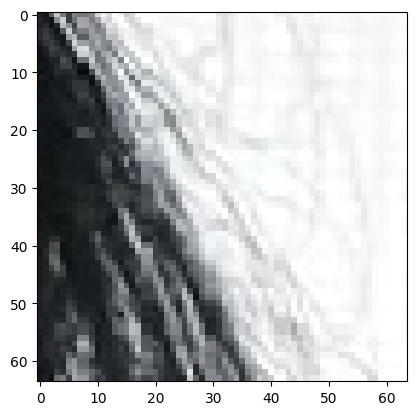

In [35]:
plt.imshow(dl_dict['img'][125].permute(1,2,0))

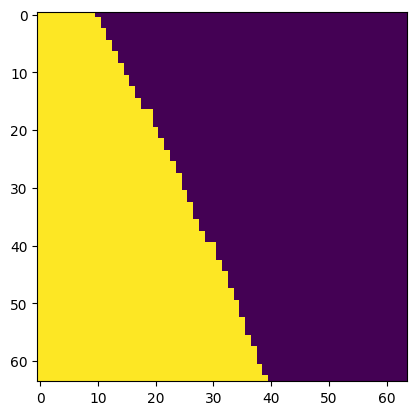

In [36]:
plt.imshow(dl_dict['label'][125].permute(1,2,0))